In [1]:
import os
import tqdm
import torch
import torchvision
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [2]:
class GetDataSet:
    def __init__(self):
        pass
        
    def FashionMinstData(self):
        """
        Class to get fashion minst data
        Args:
           None
        Returns:
          Return train and test data in Tensor format
        """
        train_data = datasets.FashionMNIST(
            root = "./data/FashionMnist/",
            train=True,
            download=True,
            transform=ToTensor(),
            target_transform=None
        )
        
        test_data = datasets.FashionMNIST(
            root = "./data/FashionMnist/",
            train = False,
            download = True,
            transform=ToTensor(),
            target_transform=None
        )
        return train_data, test_data

In [3]:
data = GetDataSet()
train, test = data.FashionMinstData()

In [4]:
len(train), len(test)

(60000, 10000)

In [5]:
train.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
test.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
train.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
image, label = train[0]
print(image.shape)

torch.Size([1, 28, 28])


In [9]:
label

9

(-0.5, 27.5, 27.5, -0.5)

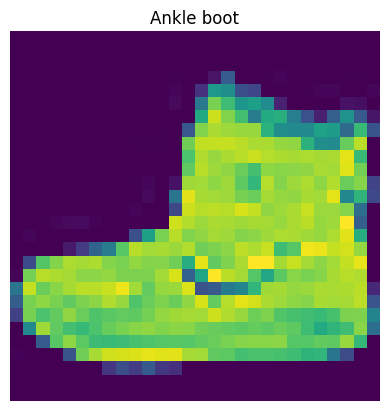

In [10]:
plt.imshow(image.reshape(28, 28, 1)) # matplotlib take H x W x C format
plt.title(train.classes[label])
plt.axis(False)

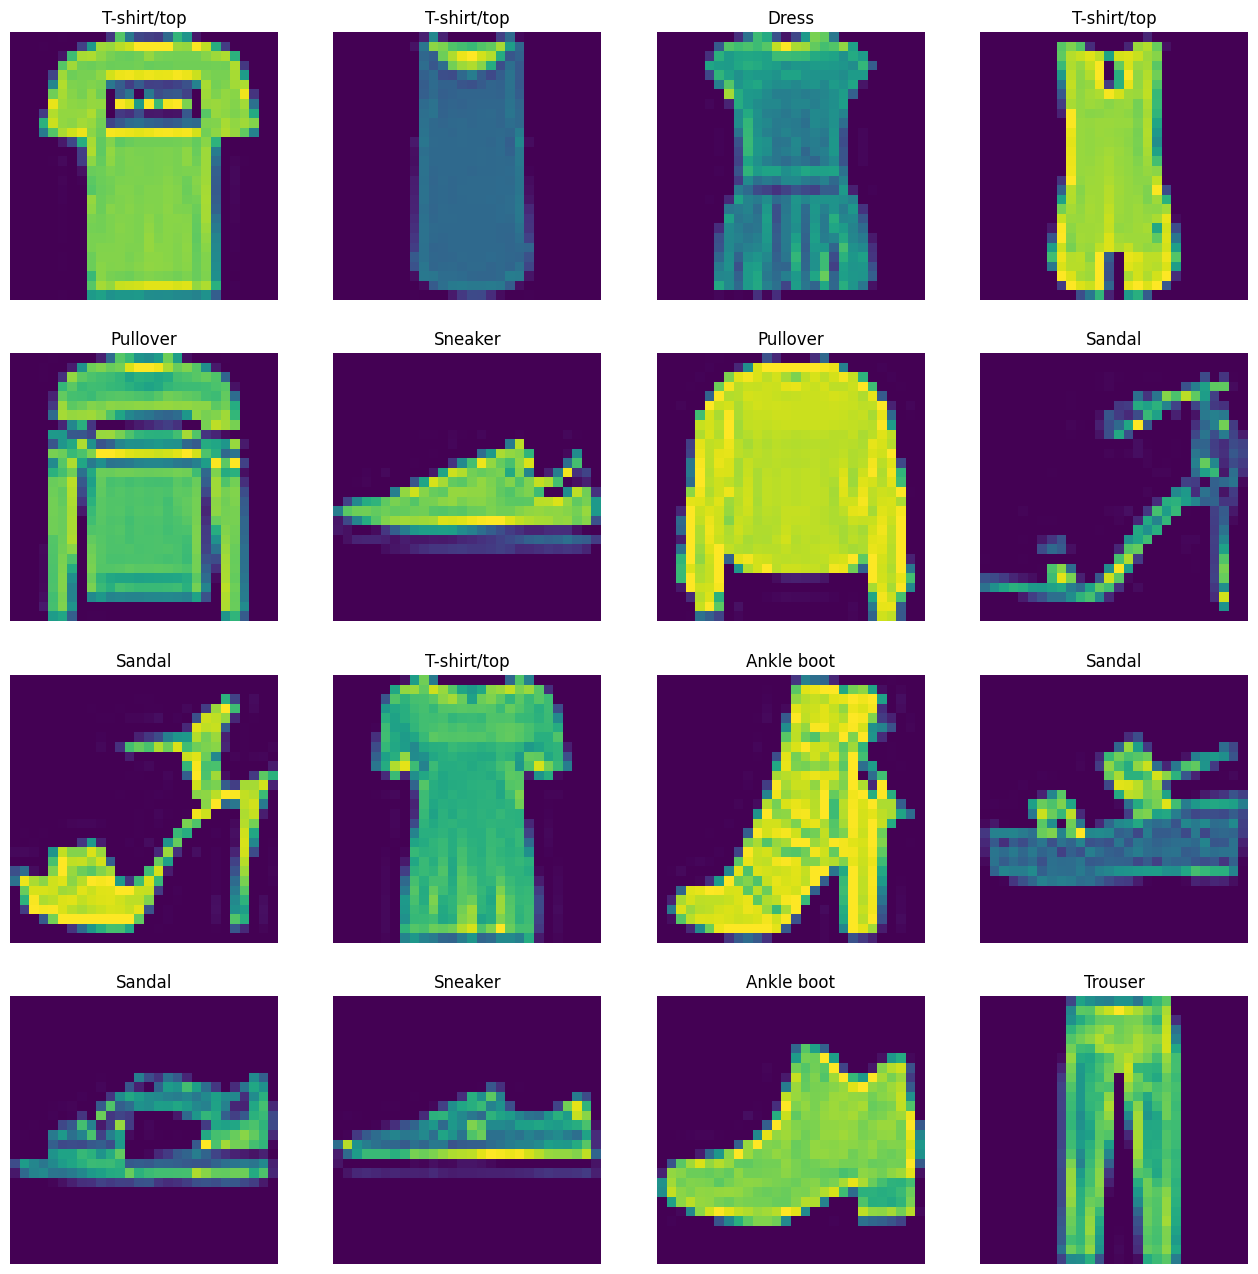

In [11]:
fig = plt.figure(figsize=(16, 16))
rows, columns = 4, 4
for i in range(1, rows * columns + 1):
    img, label = train[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.reshape(28, 28, 1))
    plt.title(train.classes[label])
    plt.axis(False)

In [12]:
class DataLoad:
    def __init__(self, batch_size: int):
        self.batch_size = batch_size
        self.shuffle = True
        
    def Data(self):
        train_dataloader = DataLoader(dataset=train, batch_size=self.batch_size, shuffle=self.shuffle)
        test_dataloder = DataLoader(dataset=test, batch_size=self.batch_size, shuffle=self.shuffle)
        return train_dataloader, test_dataloder

In [13]:
load = DataLoad(32)
train_dataloder, test_dataloder = load.Data()

In [14]:
print(f"Batches of batch_size: {len(train_dataloder)}")

Batches of batch_size: 1875


In [15]:
train_features_batch, train_labels_batch = next(iter(train_dataloder))

In [16]:
train_features_batch.shape

torch.Size([32, 1, 28, 28])

In [17]:
train_labels_batch.shape

torch.Size([32])

In [18]:
# Info about flattern layer
flattern_layer = nn.Flatten()
x_1 = train_features_batch[0]
output = flattern_layer(x_1)
x_1.shape, output.shape 

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [19]:
28 * 28 # -> One dimensions per pixel(Vector Space)

784

In [20]:
class ModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=input_shape,
                out_features=hidden_units
            ),
            nn.Linear(
                in_features=hidden_units,
                out_features=output_shape
            )
        )
    def forward(self, x):
        return self.layer_stack(x)

In [21]:
model_1 = ModelV1(
    input_shape=784,
    hidden_units=10,
    output_shape=len(train.classes)
)

In [22]:
model_1

ModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [23]:
dummy1 = torch.rand([1, 1, 28, 28])
model_1(dummy1)

tensor([[ 4.1651e-01, -1.9283e-01, -3.1424e-04,  2.2480e-01,  1.2570e-01,
          4.5864e-02, -1.0089e-01,  4.5769e-01,  9.2029e-03,  1.3438e-01]],
       grad_fn=<AddmmBackward0>)

In [24]:
class TrainModel:
    def __init__(self, model, train_dataloder, test_dataloder, epochs, lr):
        """
        Train Model with saving logs of accuracy and loss to plot the data at end of training
        Args:
          model: Take Model as input
          train_dataloderr: Take's training data
          test_dataloder: Takes testing data
          epochs: Epochs To Run
          lr: Learning Rate
        """
        self.model = model
        self.train_dataloder = train_dataloder
        self.test_dataloder = test_dataloder
        self.epochs = epochs
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
        self.train_acc = list()
        self.test_acc = list()
        self.train_loss = list()
        self.test_loss = list()
        
    def Accuracy(self, y_true, y_pred):
        """
        Calculates accuracy between predicted value and truth value
        Args:
          y_true: Truth values
          y_pred: Predicted values
        Returns:
          [torch.float]: Accuracy between y_true and y_pred
        """
        accuracy = torch.eq(y_true, y_pred).sum().item()
        acc = (accuracy / len(y_true)) * 100
        return acc
        
    def Train(self):
        """
        Training Loop for Model
        Args:
          x: Image
          y: Label
          batch: Batches in train dataloder
        Info:
          tqdm: tqdm is a progress bar library in python which will show progress bar in python
          tqdm.auto : It adapts the env if env == jupyter it shows diffrernt progress bar than python scripts
        """
        train_loss, train_acc = 0, 0
        for epoch in tqdm.auto.tqdm(range(1, self.epochs + 1)):
            for batch, (x, y) in enumerate(self.train_dataloder):
                # Set model at train mode
                self.model.train()
                # Forward Pass
                y_pred = self.model(x)
                # Calculate loss per batch
                loss = self.loss_fn(y_pred, y)
                train_loss += loss
                train_acc += self.Accuracy(y_true=y, y_pred=y_pred.argmax(dim=1))
                # Optimizer Zero Grad
                self.optimizer.zero_grad()
                # Backward loss
                loss.backward()
                # Optimizer step()
                self.optimizer.step()